In [9]:
# basics
from datetime import datetime
import time
import os 
import random
# import gresearch_crypto

# plotting
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
# correlation heatmap
from bokeh.io import output_notebook, show
from bokeh.models import (
    BasicTicker,
    ColorBar,
    ColumnDataSource,
    LinearColorMapper,
    PrintfTickFormatter,
)
from bokeh.plotting import figure
from bokeh.transform import transform

# ml shit
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy.stats as stats
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer
# stat shit
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
# models
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor


data_root = "../data/"
SEED = 2021
REMOVE_LB_TEST_OVERLAPPING_DATA = True

In [10]:
#basic functions

#this one is prob redundant
to_datetime = lambda timestamp: datetime.strftime(datetime.fromtimestamp(timestamp),"%Y-%m-%d")

get_month_timestamp = lambda timestamp: to_datetime(timestamp).month

get_month = lambda datetime: datetime.month

get_month_day = lambda datetime: datetime.strftime("%m-%d")

############# Two new features from the competition tutorial
def log_return(series, periods=1):
    return np.log(series).diff(periods=periods)

def roll(array, shift):
    # this supposebly improves the performance of np.roll
    if not (isinstance(array, np.ndarray)):
        array = np.asarray(array)
    idx = shift%len(array)
    return np.concatenate([array[-idx:], array[:-idx]])


############# from lightGBT tutorial
def upper_shadow(df):
    return df['High'] - np.maximum(df['Close'], df['Open'])

def lower_shadow(df):
    return np.minimum(df['Close'], df['Open']) - df['Low']

############# realized here needs to use some data for calculation of initial values
def realized(close, N=240):
    rt = list(np.log(C_t / C_t_1) for C_t, C_t_1 in zip(close[1:], close[:-1]))
    rt_mean = sum(rt) / len(rt)
    return np.sqrt(sum((r_i - rt_mean) ** 2 for r_i in rt) * N / (len(rt) - 1))

########## function for calling all feature creating functions
def get_features(df, Lag=True):
    df_feat = df[["Count", "Open","High", "Low", "Close", "Volume","VWAP", "Target"]].copy()
    
    df_feat["Upper_shadow"] = upper_shadow(df_feat)
    df_feat["Lower_shadow"] = lower_shadow(df_feat)

    df_feat["Volume"] = log_return(df_feat["Volume"]) # maybe Volume is fine just like that(?)
    df_feat["Count"] = log_return(df_feat["Count"])
    df_feat["VWAP"] = log_return(df_feat["VWAP"])
    df_feat = df_feat[1:] # compensate
    if Lag:
        for lag in range(1, 6):
            roll_feature = "VWAP"
            df_feat["rolled_"+roll_feature+f"_{lag}"] = \
                roll(df_feat[roll_feature].values, lag)
    
    ########### for now, simple dropna()     ########### 
    ########### later we can use reindexing  ########### 
    df_feat.dropna(inplace=True)
    # df_feat = df_feat.reindex(range(btc.index[0],btc.index[-1]+60, 60), method="pad")

    return df_feat


def Xy_model_asset(train, asset_id, Lag=True, targets=['Target']):
    df = train[train["Asset_ID"]==asset_id]

    # todo : try different features here 
    #        also, scale the features
    df_proc = get_features(df, Lag)

    df_proc["y"] = df[targets]
    # 念の為
    df_proc.dropna(how="any", inplace=True)
    X = df_proc.drop("y", axis=1)
    y = df_proc["y"]

    # todo : try different models here
    # model = LGBMRegressor()
    # model.fit(X, y)
    return X, y#, model


def scorer(model, X, y):
    # not sure how this line works, just trying
    y_pred = model.predict([X])[0]
    score = np.corrcoef(y_pred, y)
    return score

my_scorer = make_scorer(scorer)

In [11]:
df = pd.read_csv(data_root+"train.csv")
assets = pd.read_csv(data_root+"asset_details.csv")
df_grouped = df.groupby("Asset_ID")

In [12]:
btc = df_grouped.get_group(1)
eth = df_grouped.get_group(6)


btc.set_index("timestamp", inplace=True)
btc = btc.drop(columns=["Target", "Asset_ID"])
btc = btc.add_suffix("_btc")
eth.set_index("timestamp", inplace=True)
eth = eth.drop(columns=["Target", "Asset_ID"])
eth = eth.add_suffix("_eth")

btc_eth = pd.concat([btc, eth], axis=1)

# we might want to change this, like dropping for 2020 10/15, 16(this is for btc)
btc_eth.fillna(method="ffill", inplace=True)

btc_eth

,Count_btc,Open_btc,High_btc,Low_btc,Close_btc,Volume_btc,VWAP_btc,Count_eth,Open_eth,High_eth,Low_eth,Close_eth,Volume_eth,VWAP_eth
timestamp,,,,,,,,,,,,,,
1514764860,229.0,13835.194000,14013.800000,13666.11,13850.176000,31.550062,13827.062093,173.0,738.302500,746.00,732.51,738.507500,335.987856,738.839291
1514764920,235.0,13835.036000,14052.300000,13680.00,13828.102000,31.046432,13840.362591,192.0,738.507500,745.14,732.49,738.260000,232.793141,738.268967
1514764980,528.0,13823.900000,14000.400000,13601.00,13801.314000,55.061820,13806.068014,120.0,738.332500,745.12,730.00,737.502500,174.138031,737.994457
1514765040,435.0,13802.512000,13999.000000,13576.28,13768.040000,38.780529,13783.598101,156.0,737.222500,744.69,728.93,737.102500,165.383926,737.303631
1514765100,742.0,13766.000000,13955.900000,13554.44,13724.914000,108.501637,13735.586842,118.0,736.530000,743.80,727.11,735.705000,193.078039,736.163026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1632182160,1940.0,42983.780000,43001.850849,42878.26,42899.012857,56.850913,42935.489499,2162.0,2973.728686,2976.10,2962.09,2964.711429,751.256906,2968.339295
1632182220,2026.0,42904.197143,42932.000000,42840.16,42860.005714,80.993326,42879.576084,1976.0,2965.461446,2967.95,2958.05,2960.845714,729.113672,2963.499199
1632182280,1986.0,42859.385714,42887.500000,42797.20,42827.020000,65.677734,42844.090693,2262.0,2960.321429,2962.60,2954.14,2957.398571,807.935362,2958.464868


In [6]:
# for plotting nans
def reindex_nans(df, window_start="2018-01-01", window_end="2021-09-21"):
    df_copy = df.copy()
    df_copy.set_index('timestamp', inplace=True)
    df_copy = df_copy.reindex(range(df_copy.index[0], df_copy.index[-1]+60, 60))#, method="pad")
    print(df_copy.isna().sum())
    
    df_nans = df_copy.Asset_ID.isna().astype(int)

    # datatime index
    df_nans.index = map(to_datetime,df_copy.index)
    # window
    df_nans = df_nans[window_start:window_end]
    plt.figure(figsize=(10,5))
    df_nans.plot()
    plt.xticks(rotation=45)
    plt.show()

for i in assets.index:

    mini = assets.iloc[i]

    print(mini.Asset_Name)

    reindex_nans(df_grouped.get_group(mini.Asset_ID))#, "2019-10-01", "2019-10-01")


Bitcoin Cash
Asset_ID    3423
Count       3423
Open        3423
High        3423
Low         3423
Close       3423
Volume      3423
VWAP        3423
Target      8284
dtype: int64


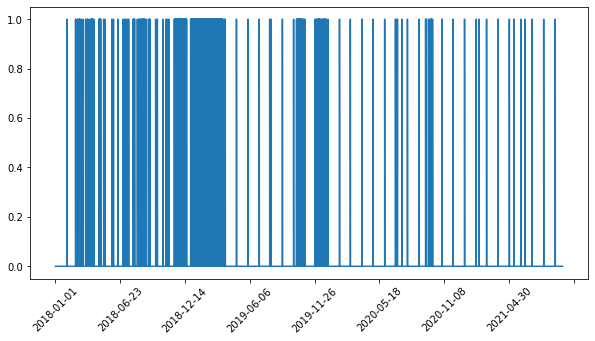

Binance Coin
Asset_ID    14341
Count       14341
Open        14341
High        14341
Low         14341
Close       14341
Volume      14341
VWAP        14341
Target      27756
dtype: int64


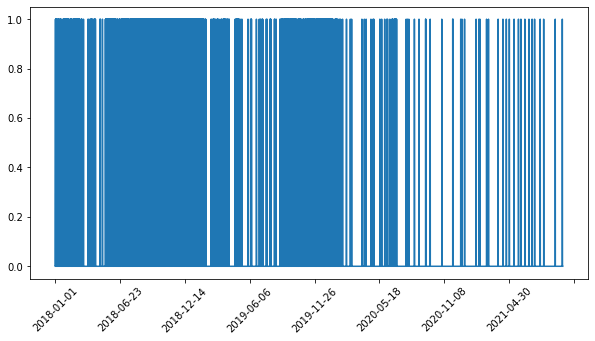

Bitcoin
Asset_ID    678
Count       678
Open        678
High        678
Low         678
Close       678
Volume      678
VWAP        678
Target      982
dtype: int64


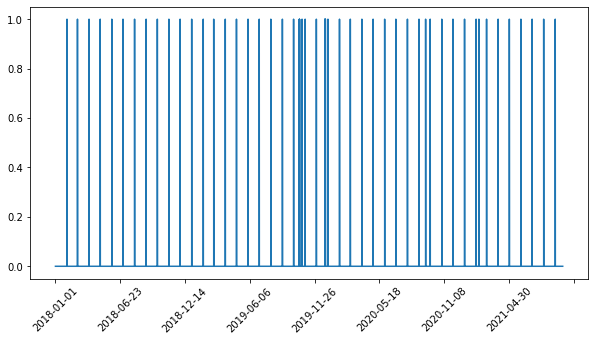

EOS.IO
Asset_ID    1820
Count       1820
Open        1820
High        1820
Low         1820
Close       1820
Volume      1820
VWAP        1820
Target      4122
dtype: int64


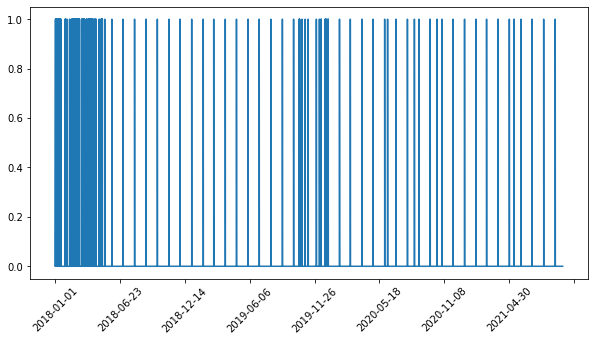

Ethereum Classic
Asset_ID     5833
Count        5833
Open         5833
High         5833
Low          5833
Close        5833
Volume       5833
VWAP         5833
Target      15159
dtype: int64


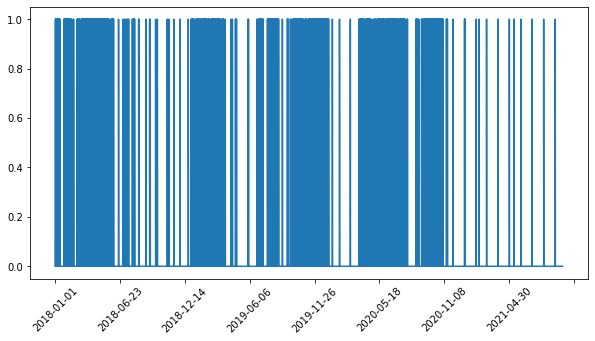

Ethereum
Asset_ID     760
Count        760
Open         760
High         760
Low          760
Close        760
Volume       760
VWAP         760
Target      1100
dtype: int64


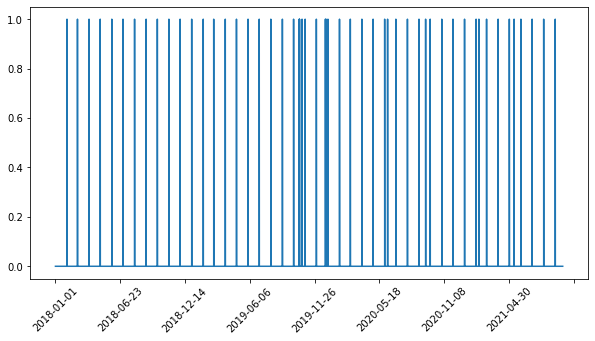

Litecoin
Asset_ID     930
Count        930
Open         930
High         930
Low          930
Close        930
Volume       930
VWAP         930
Target      1451
dtype: int64


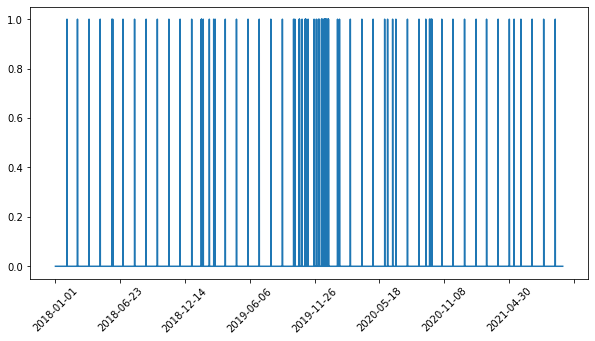

Monero
Asset_ID    255699
Count       255699
Open        255699
High        255699
Low         255699
Close       255699
Volume      255699
VWAP        255699
Target      495302
dtype: int64


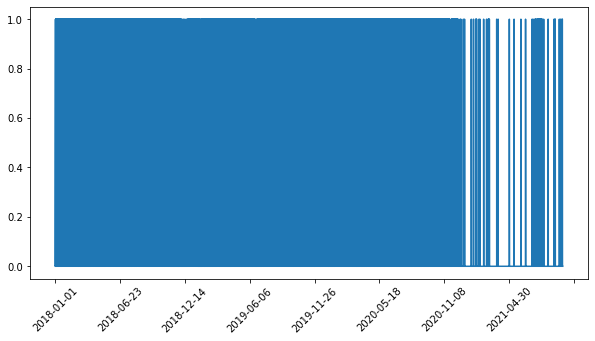

TRON
Asset_ID    29264
Count       29264
Open        29264
High        29264
Low         29264
Close       29264
Volume      29264
VWAP        29264
Target      50278
dtype: int64


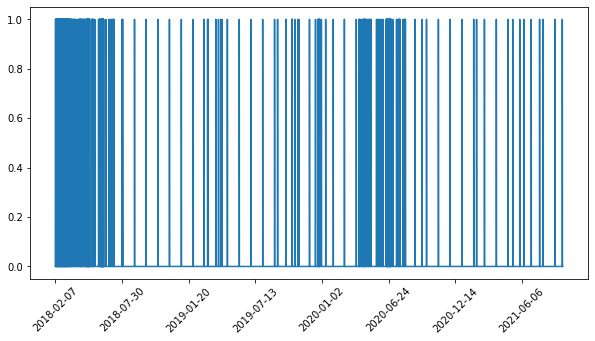

Stellar
Asset_ID    110539
Count       110539
Open        110539
High        110539
Low         110539
Close       110539
Volume      110539
VWAP        110539
Target      172355
dtype: int64


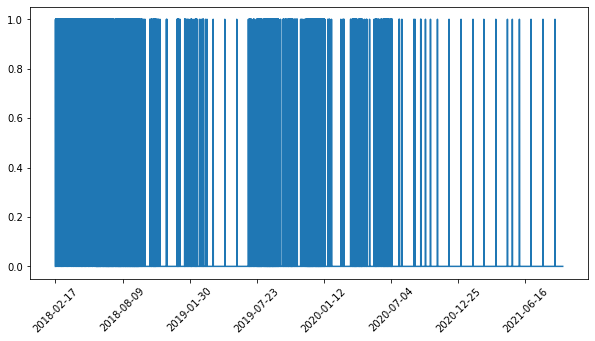

Cardano
Asset_ID    11903
Count       11903
Open        11903
High        11903
Low         11903
Close       11903
Volume      11903
VWAP        11903
Target      30634
dtype: int64


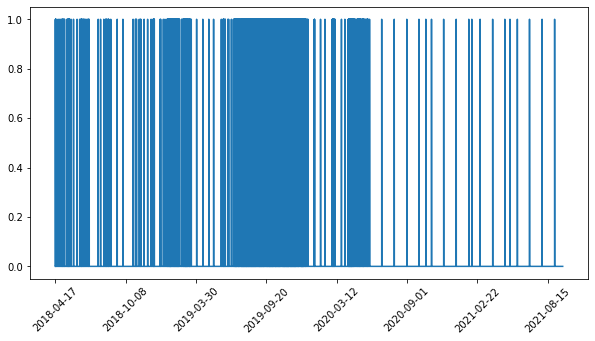

IOTA
Asset_ID    180083
Count       180083
Open        180083
High        180083
Low         180083
Close       180083
Volume      180083
VWAP        180083
Target      373189
dtype: int64


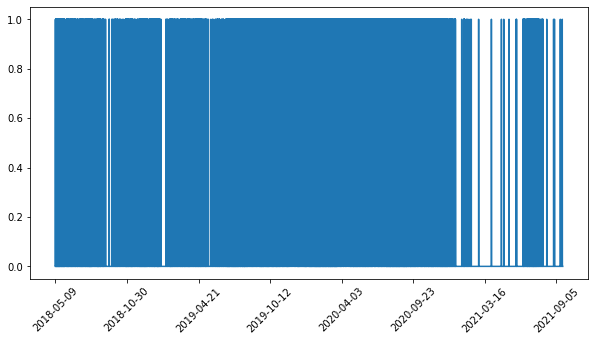

Maker
Asset_ID    1099783
Count       1099783
Open        1099783
High        1099783
Low         1099783
Close       1099783
Volume      1099783
VWAP        1099792
Target      1139808
dtype: int64


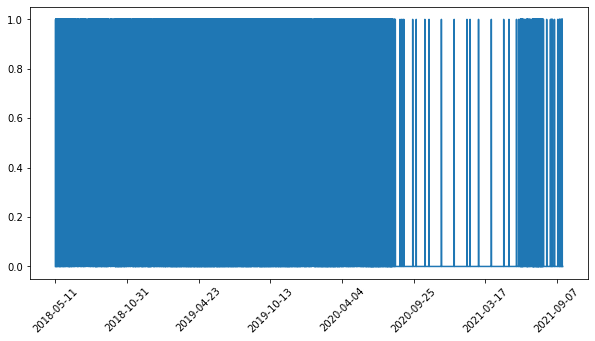

Dogecoin
Asset_ID    128181
Count       128181
Open        128181
High        128181
Low         128181
Close       128181
Volume      128181
VWAP        128181
Target      273155
dtype: int64


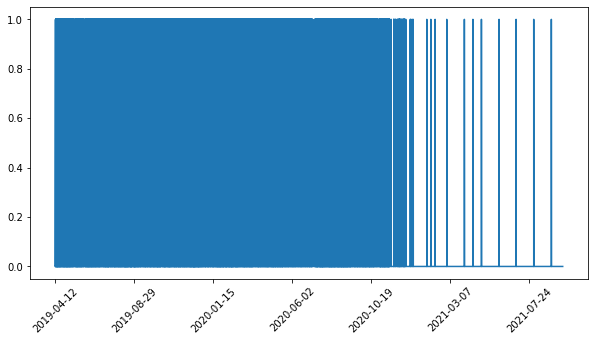

In [7]:
for i in assets.index:

    mini = assets.iloc[i]

    print(mini.Asset_Name)

    reindex_nans(df_grouped.get_group(mini.Asset_ID))#, "2019-10-01", "2019-10-01")

In [13]:
#this section takes time to run(1min)

df_features = btc_eth.copy()
suffixes = ["_btc", "_eth"]

for suffix in suffixes:
    df_features["logprice"+suffix] = np.log(df_features["Close"+suffix]) 
    df_features["Volatility"+suffix] = np.log(df_features["High"+suffix])\
        - np.log(df_features["Close"+suffix])
    df_features = df_features.drop(columns=["Close"+suffix, "High"+suffix,\
         "Low"+suffix, "Open"+suffix, "VWAP"+suffix])

def get_time_fractions(date):

    def s(date):# returns seconds since epoch
        return time.mktime(date.timetuple())

    year = date.year
    month = date.month
    day = date.day
    dayofweek = date.dayofweek

    start_of_day = datetime(year = year, month = month, day = day, hour = 0, minute = 0, second = 0)
    day_sec = 60*60*24

    frac_day = (s(date) - s(start_of_day))/day_sec # how much time has passed during that day

    frac_week  = (dayofweek + frac_day) / 7 # how much time has passed during the week

    start_of_month = datetime(year=year, month=month, day=1)
    start_of_next_month = datetime(year=year, month=month+1, day=1) if month < 12 \
        else datetime(year=year+1, month=1, day=1)
    # here we use datetime function because we don't know how many days this next month is 
    frac_month = (s(date) - s(start_of_month)) / (s(start_of_next_month) - s(start_of_month))

    start_of_year = datetime(year=year, month=1, day=1)
    start_of_next_year = datetime(year=year+1, month=1, day=1)

    frac_year = (s(date) - s(start_of_year)) / (s(start_of_next_year) - s(start_of_year))

    return frac_day, frac_week, frac_month, frac_year

datetimes = pd.Series(df_features.index).astype("datetime64[s]")

df_features["frac_day"], df_features["frac_week"], df_features['frac_of_month'], \
    df_features['frac_of_year'] = zip(*datetimes.map(get_time_fractions))

In [14]:
# calculate 2-asset targets(not 14 asset target)

df_logprices = df_features[["logprice_btc", "logprice_eth"]]

# we don't need to shift index too?
df_returns = df_logprices.shift(-16) - df_logprices.shift(-1)

for suffix in suffixes:
    df_returns.rename(columns={"logprice"+suffix : "R"+suffix}, inplace=True)


In [15]:
assets =  assets[(assets["Asset_ID"] == 1) | (assets["Asset_ID"] == 6)]

assets = assets.sort_values(by=["Asset_ID"])

weights = assets["Weight"].to_numpy()
weights = weights.reshape(len(weights), 1)

R = df_returns.to_numpy()# to array
weights_sum = np.sum(weights)
M = np.dot(R, weights) / weights_sum # weighted average => log_btc*w_btc + log_eth*w_eth
df_M = pd.DataFrame(data=M, index=df_returns.index, columns=["M"])
R.shape,weights.shape, M.shape

df_R_M = df_returns.copy()

for col in df_R_M.columns:
    df_R_M[col] = df_R_M[col] * df_M["M"] # calculated R・M here
for suffix in suffixes:
    df_R_M.rename(columns={"R"+suffix:"R_M"+suffix}, inplace=True)
df_R_M_rolling = df_R_M.rolling(window=3750).mean()


# creating M^2 
df_M2 = df_M ** 2
df_M2.rename(columns={"M" : "M2"}, inplace = True)
df_M2_rolling = df_M2.rolling(window=3750).mean()


df_betas = df_R_M_rolling.copy()    
for col in df_betas.columns: # columns = [R_M_btc	R_M_eth]   
    df_betas[col] = df_betas[col] / df_M2_rolling["M2"] # caculating <R・M>/<M^2> here
for suffix in suffixes: # beta = <R・M>/<M^2> 
    df_betas.rename(columns={"R_M"+suffix : "beta"+suffix}, inplace = True)

df_targets = df_returns.copy()
for suffix in suffixes:
    df_targets["R"+suffix] -= df_betas["beta"+suffix] * df_M["M"] # R^a - β^a
    df_targets.rename(columns={"R"+suffix: "Target"+suffix}, inplace=True)

df_features_targets = pd.concat([df_features, df_betas, df_targets], axis=1)

df_features_targets = df_features_targets.iloc[3750:-16] # drop nan rows

In [ ]:
kf = TimeSeriesSplit(n_splits=5)
model = LGBMRegressor()
scores = []
X, y = Xy_model_asset(df_features_targets, 1)
for train_idx, test_idx in kf.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores.append(np.corrcoef(y_pred, y_test))

print(scores)

(-0.0, 0.1)

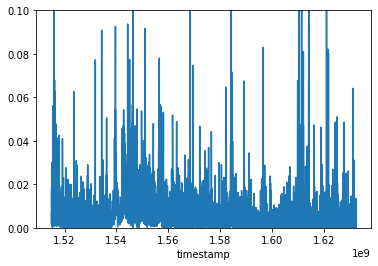

In [26]:
df_features_targets.Volatility_btc.plot()
plt.ylim(0.0, 0.1)

<AxesSubplot:xlabel='timestamp'>

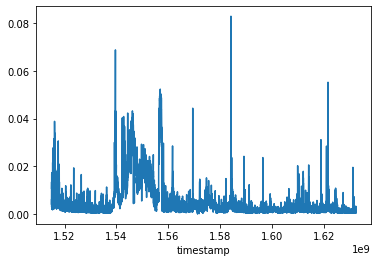

In [32]:
df_features_targets["Volatility_btc"].rolling(window=20).mean().plot()


In [ ]:
# since target and beta have super strong multi-colinearity,
# (because of residualization) we will remove the corresponding 
# features of eth for them
